In [1]:
import os, shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.3.0
 GPU: /device:GPU:0


In [3]:
#the paths to change: (and also need to change number of prediciton column)

#model path
model_path = './models/saved_VGG16_AL1'

#raw images:
aerial_folder = '../data/pics/raw/Florence_20180917a_jpgs/'

#import prediction csv
preds_df = pd.read_csv('../data/tables/FlorencePredsSecondLabels20180917a.csv')

#new csv to save
newpredcsv = '../data/tables/FlorencePredsThirdLabels20180917a.csv'

ALPATH = '../data/pics/modeltoLabeler/roundThree/Florence/'

In [2]:
# load model into tf
model = tf.keras.models.load_model(model_path, compile = True)

In [4]:
#load images from Directory
aerials = []
labels = []
for img in os.listdir(aerial_folder):
    #pull the name of the image
    labels.append(img)
    #pull the image
    img = os.path.join(aerial_folder, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size=(416,416))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    aerials.append(img)
    

In [5]:
#run through model for prediction
aerials = np.vstack(aerials)
wpreds = model.predict(aerials)
print(wpreds)

[[0.98054916]
 [0.06998949]
 [0.00811334]
 ...
 [0.        ]
 [0.        ]
 [0.02135681]]


(array([2808.,  150.,  105.,   89.,   81.,   71.,   62.,   58.,   64.,
         154.]),
 array([0.        , 0.09976231, 0.19952463, 0.29928693, 0.39904925,
        0.49881157, 0.59857386, 0.6983362 , 0.7980985 , 0.8978608 ,
        0.99762315], dtype=float32),
 <a list of 10 Patch objects>)

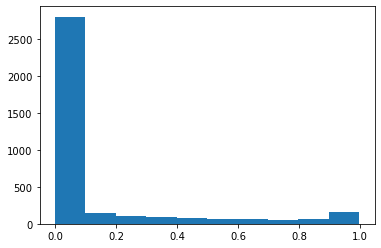

In [6]:
#just an idiot check
#np.histogram(wpreds)
fig,ax = plt.subplots(1,1)
ax.hist(wpreds, bins=10)

In [7]:
aerial_labels = np.vstack(np.asarray(labels))
print(aerial_labels)

[['P26058176.jpg']
 ['P26055682.jpg']
 ['P26056205.jpg']
 ...
 ['C26050272.jpg']
 ['C26052467.jpg']
 ['P26055737.jpg']]


In [8]:
#make them a dataframe
newpred_df = pd.DataFrame(data=np.hstack((aerial_labels,wpreds)), columns=["image", "prediction3"])
newpred_df

,image,prediction2
0,P26058176.jpg,0.98054916
1,P26055682.jpg,0.069989495
2,P26056205.jpg,0.008113342
3,P26056072.jpg,0.06418635
4,P26047198.jpg,2.3647576e-08
...,...,...
3637,P26054269.jpg,9.5634405e-08
3638,P26048156.jpg,9.405134e-06
3639,C26050272.jpg,0.0
3640,C26052467.jpg,0.0


In [9]:
#append/join to catalog df and prediction via the 'image' column in hurricane.csv save as csv
preds = preds_df.join(newpred_df.set_index('image'), on='image')
preds.head()

,Unnamed: 0,file,storm_id,archive,image,size,date,ul_lat,ur_lat,geom_checksum,lr_lat,ll_lat,ul_lon,lr_lon,ur_lon,ll_lon,prediction,pred_certainty,labeled,prediction2
0,1759,20180917a_jpgs/jpgs/P26058502.jpg,florence,20180917a_jpgs,P26058502.jpg,6174041,2018/09/17,34.928300,34.931574,827ccdd65dc6e468901b9074188aa67b,34.927478,34.925379,-76.224670,-76.216952,-76.218977,-76.220528,0.499669,0.000331,1.0,0.99326175
1,2977,20180917a_jpgs/jpgs/P26059434.jpg,florence,20180917a_jpgs,P26059434.jpg,5350431,2018/09/17,35.235277,35.230687,ee6643d42ab5e4b7613167a6ed657832,35.226798,35.229446,-75.550434,-75.548640,-75.542968,-75.553097,0.499333,0.000667,1.0,0.47330174
2,1814,20180917a_jpgs/jpgs/P26057539.jpg,florence,20180917a_jpgs,P26057539.jpg,5689109,2018/09/17,34.672949,34.670919,d4986ea1ecee8ca54ab5e353af63baae,34.667243,34.668502,-76.607581,-76.604063,-76.601121,-76.608181,0.501626,0.001626,1.0,0.59414446
3,2606,20180917a_jpgs/jpgs/P26059328.jpg,florence,20180917a_jpgs,P26059328.jpg,5959711,2018/09/17,35.231828,35.232004,31fc396ed145b440f6028ceb9797ce7b,35.225999,35.225774,-75.640628,-75.632680,-75.631187,-75.638167,0.497229,0.002771,1.0,0.000464963
4,1752,20180917a_jpgs/jpgs/P26057234.jpg,florence,20180917a_jpgs,P26057234.jpg,6590240,2018/09/17,34.696049,34.695104,23f7e3c770a59aff24b40fce3334365d,34.691123,34.691740,-76.831236,-76.826622,-76.824562,-76.830926,0.503741,0.003741,1.0,0.0030704923


In [10]:
#make new column certainty of prediction, from 0 to 0.5... 0 is smallest certainty
preds["pred_certainty3"] = abs(preds["prediction3"].astype(float) - 0.5)

#select top 50 each that have not been labeled
uncertain_preds = preds[preds.labeled.isna()].nsmallest(100, 'pred_certainty3')

uncertain_preds.head()

maxval = max(uncertain_preds['pred_certainty3'])

#add labeled = 2 for batch 2
preds.loc[(preds['pred_certainty3'] <= maxval) & (preds['labeled'].isna()), 'labeled'] = 3

preds.head()
#save the data
preds.to_csv(newpredcsv, index=False)

In [11]:
#add the path
uncertain_preds['Image_Path'] = aerial_folder + uncertain_preds['image'].astype(str)

#pull out the list from the df
Labeled_list= uncertain_preds['Image_Path'].tolist()

#move those on the list
for f in Labeled_list:
    shutil.copy(f, ALPATH)